In [7]:
import torch
from ultralytics import YOLO
from attacks import disappearance_dag_attack,targeted_dag_attack, fool_detectors_attack
from util import compare_original_and_adversarial, compare_original_and_adversarial_png


In [8]:
model = YOLO("yolov8n_road.pt")
image_path = "im2.jpg"

# Disappearance DAG Attack

This attack is a DAG-like multi-iteration approach that targets object detectors like YOLOv8. The goal of the attack is to **push all high-confidence predictions away from their currently predicted class** by perturbing the input image. Key characteristics of the attack include:

- **Targeting High-Confidence Predictions:**  
  The attack first identifies predictions from the raw model that exceed a given confidence threshold and belong to classes detected by the high-level model.

- **Loss Construction:**  
  For each selected prediction, the loss is defined as the negative logit for its predicted class. Minimizing this loss pushes the detector to lower its confidence in those predictions.

- **Iterative Update:**  
  The attack performs an iterative update on the image using an L-infinity (sign-based) step. At each iteration, the image is updated by adding a small perturbation in the direction of the gradient sign.

- **Early Stopping:**  
  If, during any iteration, no predictions are above the threshold, the attack stops early.

- **Objective:**  
  The overall objective is to make the objects "disappear" from the detector's view by reducing the confidence of their detections, effectively fooling the detector.

This method demonstrates a way to manipulate object detection systems by directly targeting the prediction confidence of the detector.

- **paper:** Adversarial Examples for Semantic Segmentation and Object Detection

In [4]:
adv_image = disappearance_dag_attack(image_path, raw_model_path="yolov8n_road.pt", high_level_model_path="yolov8n_road.pt",num_iterations=20, gamma=0.003)


0: 640x640 2 cars, 1 trafficLight-Green, 1 truck, 323.3ms
Speed: 0.0ms preprocess, 323.3ms inference, 16.5ms postprocess per image at shape (1, 3, 640, 640)
Iteration 0: #rows_to_attack=4660, loss=-27.7625

0: 640x640 (no detections), 285.1ms
Speed: 0.0ms preprocess, 285.1ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)
Iteration 1: no rows above threshold => stopping early.


Running prediction on original tensor...



0: 640x640 2 cars, 1 trafficLight-Green, 1 truck, 334.8ms
Speed: 0.0ms preprocess, 334.8ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)
Running prediction on loaded adversarial tensor...

0: 640x640 (no detections), 202.8ms
Speed: 0.0ms preprocess, 202.8ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


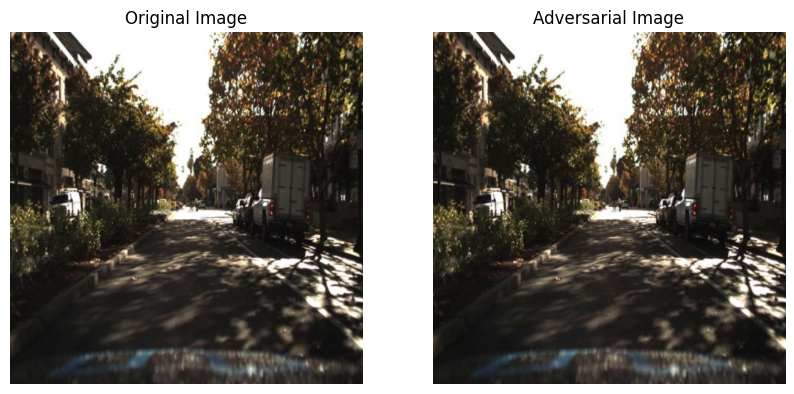

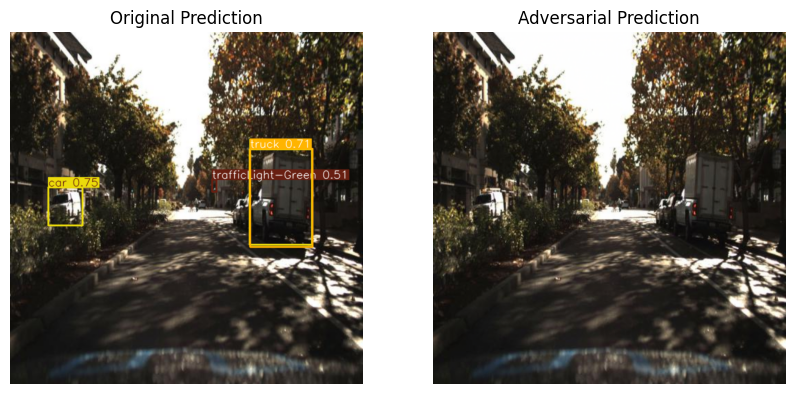

In [ ]:
compare_original_and_adversarial(model ,image_path,adv_image,0.5)

# Targeted DAG Attack

This attack is a targeted version of the DAG (Directed Acyclic Graph) attack that manipulates the predictions of YOLOv8. It works as follows:

1. **Initial Target Identification:**  
   The attack first runs the high-level model on the clean image to determine the original target classes (i.e. the classes that appear above a confidence threshold).

2. **Gradient-Based Targeted Update:**  
   - For predictions that belong to the original target classes and exceed a confidence threshold, the attack computes a loss that encourages the network’s logit for the adversarial class to be higher than the original predicted class.
   - If no predictions from the target classes remain, the loss is computed globally by boosting the adversarial class across all predictions.

3. **Iterative Update:**  
   The adversarial image is updated iteratively using an L_inf update (i.e. subtracting the sign of the gradient scaled by a small step size) to push the network’s predictions towards the adversarial class.

4. **Stop Condition:**  
   The attack stops early when the high-level model predicts that the adversarial class is present and none of the original target classes remain.

This method, sometimes referred to as the **Targeted DAG Attack**, demonstrates a strategy to not only diminish unwanted detections but also to force the network into predicting a desired (adversarial) class.

**paper:** Adversarial Examples for Semantic Segmentation and Object Detection

In [ ]:
adv_image_targeted = targeted_dag_attack(
    image_path=image_path,
    raw_model_path="yolov8n_road.pt",
    high_level_model_path="yolov8n_road.pt",
    adversarial_class=0,
    num_iterations=50,
    gamma=0.003,
    conf_threshold=0.5,
    device='cpu')


0: 640x640 2 cars, 1 trafficLight-Green, 1 truck, 801.4ms
Speed: 0.0ms preprocess, 801.4ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 640)
Original classes above conf=0.5: {1, 10, 4}

0: 640x640 (no detections), 380.6ms
Speed: 0.0ms preprocess, 380.6ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)
Iteration 0: #rows_to_attack=4660, loss=-27.7528

0: 640x640 2 cars, 259.5ms
Speed: 0.0ms preprocess, 259.5ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 640)
Iteration 1: #rows_to_attack=3946, loss=-11.6521

0: 640x640 (no detections), 263.6ms
Speed: 0.0ms preprocess, 263.6ms inference, 9.4ms postprocess per image at shape (1, 3, 640, 640)
Iteration 2: #rows_to_attack=4189, loss=-11.6686

0: 640x640 (no detections), 276.1ms
Speed: 0.0ms preprocess, 276.1ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)
Iteration 3: #rows_to_attack=3745, loss=-0.6615

0: 640x640 (no detections), 263.8ms
Speed: 0.0ms preprocess, 263.8ms inf

Running prediction on original tensor...



0: 640x640 2 cars, 1 trafficLight-Green, 1 truck, 344.1ms
Speed: 0.0ms preprocess, 344.1ms inference, 11.2ms postprocess per image at shape (1, 3, 640, 640)
Running prediction on loaded adversarial tensor...

0: 640x640 3 trafficLights, 267.2ms
Speed: 0.0ms preprocess, 267.2ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)


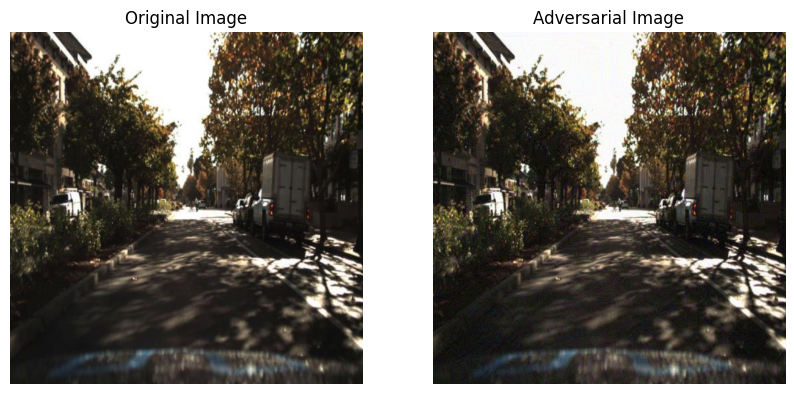

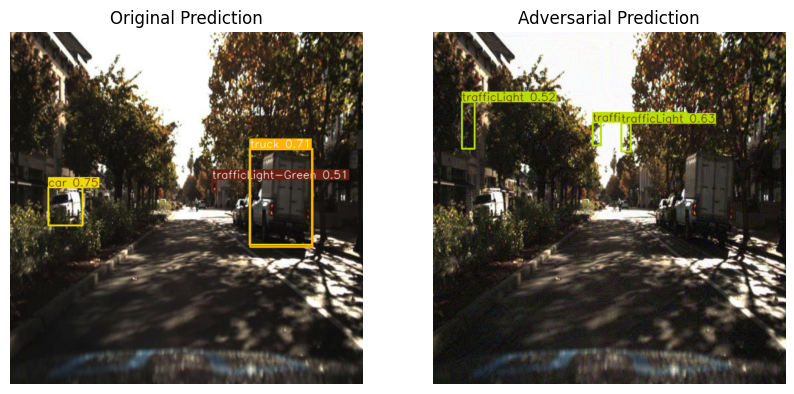

In [10]:
compare_original_and_adversarial(model ,image_path,adv_image_targeted ,0.5)

In [11]:
adv_image_targeted = targeted_dag_attack(
    image_path="000000000001.jpg",
    raw_model_path="yolov8n.pt",
    high_level_model_path="yolov8n.pt",
    adversarial_class=0,
    num_iterations=50,
    gamma=0.003,
    conf_threshold=0.5,
    device='cpu')


0: 480x640 1 car, 1 truck, 1 parking meter, 457.5ms
Speed: 0.0ms preprocess, 457.5ms inference, 12.7ms postprocess per image at shape (1, 3, 480, 640)
Original classes above conf=0.5: {2, 12, 7}

0: 480x640 1 train, 1 truck, 256.4ms
Speed: 0.0ms preprocess, 256.4ms inference, 3.6ms postprocess per image at shape (1, 3, 480, 640)
Iteration 0: #rows_to_attack=1499, loss=-15.6610

0: 480x640 1 train, 248.4ms
Speed: 0.0ms preprocess, 248.4ms inference, 10.0ms postprocess per image at shape (1, 3, 480, 640)
Iteration 1: #rows_to_attack=753, loss=-8.0866

0: 480x640 1 bus, 1 train, 228.6ms
Speed: 0.0ms preprocess, 228.6ms inference, 6.4ms postprocess per image at shape (1, 3, 480, 640)
Iteration 2: #rows_to_attack=433, loss=-2.6065

0: 480x640 1 bus, 227.8ms
Speed: 0.0ms preprocess, 227.8ms inference, 5.1ms postprocess per image at shape (1, 3, 480, 640)
Iteration 3: #rows_to_attack=386, loss=-0.0071

0: 480x640 (no detections), 499.0ms
Speed: 0.0ms preprocess, 499.0ms inference, 9.1ms post

Running prediction on original tensor...

0: 480x640 1 car, 1 truck, 1 parking meter, 277.4ms
Speed: 0.0ms preprocess, 277.4ms inference, 9.1ms postprocess per image at shape (1, 3, 480, 640)
Running prediction on loaded adversarial tensor...

0: 480x640 1 person, 1 train, 312.7ms
Speed: 0.0ms preprocess, 312.7ms inference, 9.2ms postprocess per image at shape (1, 3, 480, 640)


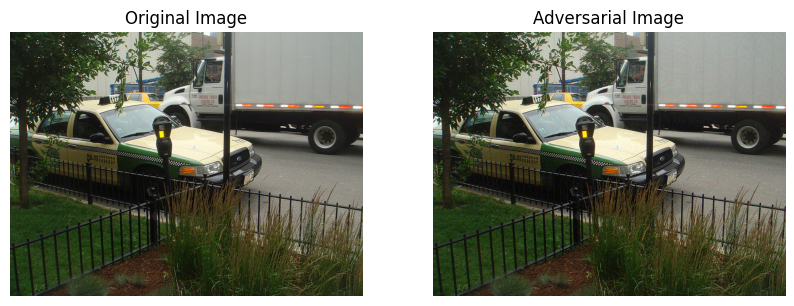

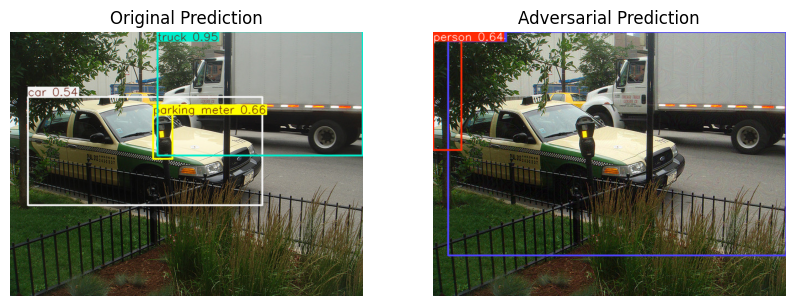

In [12]:
COCO_model = YOLO("yolov8n.pt")
compare_original_and_adversarial(COCO_model ,"000000000001.jpg",adv_image_targeted ,0.5)

# Adversarial Examples that Fool Detectors

This attack, inspired by the paper *"Adversarial Examples that Fool Detectors"*, targets object detectors—specifically YOLOv8—to reduce the confidence in detecting stop signs by defualt or any list of input targets. The key components of the attack are:

- **Iterative Gradient Descent:** The attack iteratively updates the input image using the sign of the gradient (L_inf update) to minimize the detector's confidence score for stop signs.
- **Dual Loss Function:**  
  - **Detector Loss:** The mean confidence score for stop sign detections is minimized.  
  - **L2 Penalty:** An L2 regularization term ensures that the adversarial image remains similar to the original, limiting perceptual changes.
- **Early Stopping:** The process terminates early if the high-level detector no longer detects any of the target classes (the defualt target class is the stop sign), ensuring efficiency and effectiveness.
- **Real-World Implications:** By fooling detectors in both digital and potentially physical scenarios, this attack raises significant safety concerns, especially in safety-critical applications such as autonomous vehicles.
- **paper:** Adversarial Examples that Fool Detectors


In [ ]:
model = YOLO("yolov8n.pt")
image_path = "stop.jpg"
# Set attack parameters
num_iterations = 20       # Number of iterations for the attack
gamma = 0.01              # Step size (L_inf update magnitude)
conf_threshold = 0.2  # Confidence threshold for high-level model predictions
lambda_reg = 0.01         # Weight for L2 penalty to preserve the original image appearance
device = 'cpu'           # or 'cpu'

# Run the attack
adv_image = fool_detectors_attack(
    image_path=image_path,
    raw_model_path="yolov8n.pt",
    high_level_model_path="yolov8n.pt",
    num_iterations=num_iterations,
    gamma=gamma,
    conf_threshold=conf_threshold,
    lambda_reg=lambda_reg,
    device=device
)


0: 640x640 1 stop sign, 401.9ms
Speed: 0.0ms preprocess, 401.9ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 640)
Iteration 0: Loss_det=0.5001, Loss_L2=0.0000, Total_loss=0.5001

0: 640x640 1 stop sign, 300.6ms
Speed: 0.0ms preprocess, 300.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)
Iteration 1: Loss_det=0.5001, Loss_L2=0.0000, Total_loss=0.5001

0: 640x640 1 stop sign, 266.7ms
Speed: 0.0ms preprocess, 266.7ms inference, 9.3ms postprocess per image at shape (1, 3, 640, 640)
Iteration 2: Loss_det=0.5000, Loss_L2=0.0000, Total_loss=0.5000

0: 640x640 2 beds, 271.3ms
Speed: 0.0ms preprocess, 271.3ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)
Iteration 3: No target objects detected. Early stopping.


Running prediction on original tensor...

0: 640x640 1 stop sign, 293.4ms
Speed: 0.0ms preprocess, 293.4ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)
Running prediction on loaded adversarial tensor...

0: 640x640 1 bed, 274.2ms
Speed: 0.0ms preprocess, 274.2ms inference, 8.2ms postprocess per image at shape (1, 3, 640, 640)


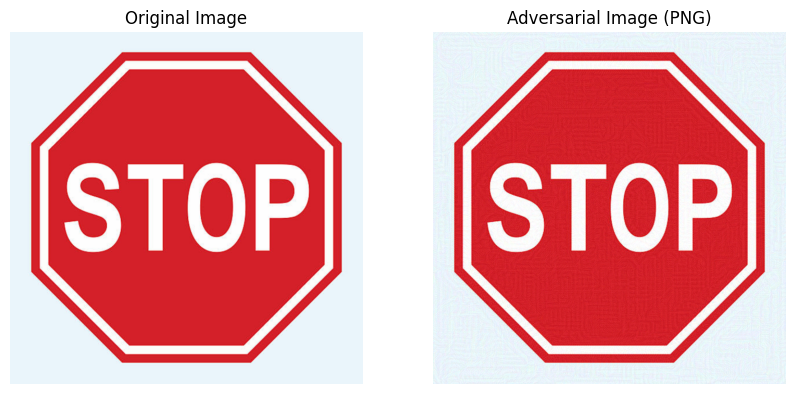

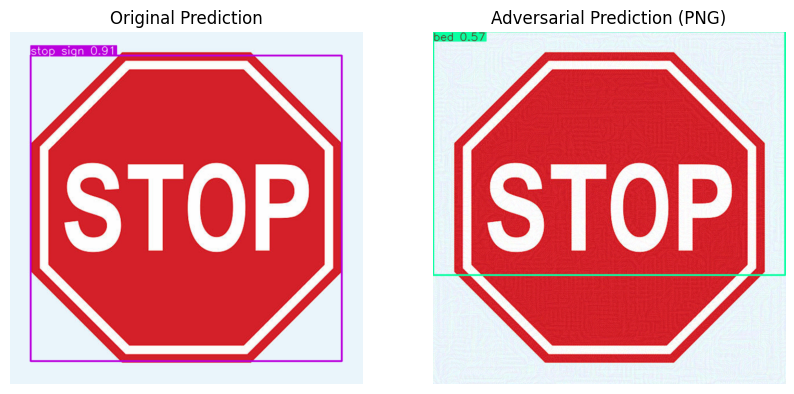

In [ ]:
compare_original_and_adversarial_png(COCO_model, image_path, adv_image,0.5)